In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

# Prepare data

In [3]:
X = conf
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]

In [4]:
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
print(f'Max h21: {h21max}, Min h21: {h21min} ')
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
print(f'Max h31: {h31max}, Min h31: {h31min} ')
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
print(f'Max h22: {h22max}, Min h22: {h22min} ')

Max h21: 33, Min h21: 0 
Max h31: 426, Min h31: 0 
Max h22: 1752, Min h22: 0 


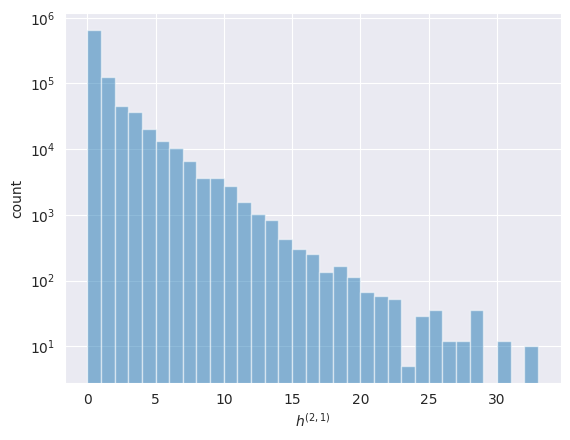

In [5]:
plt.hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
plt.xlabel('$h^{(2,1)}$')
plt.ylabel('count')
plt.yscale('log')

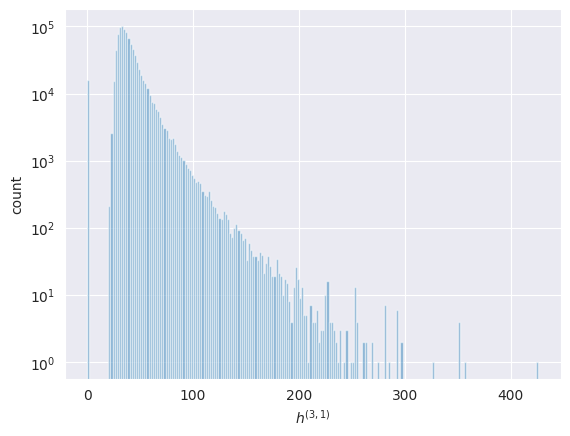

In [6]:
plt.hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
plt.xlabel('$h^{(3,1)}$')
plt.ylabel('count')
plt.yscale('log')

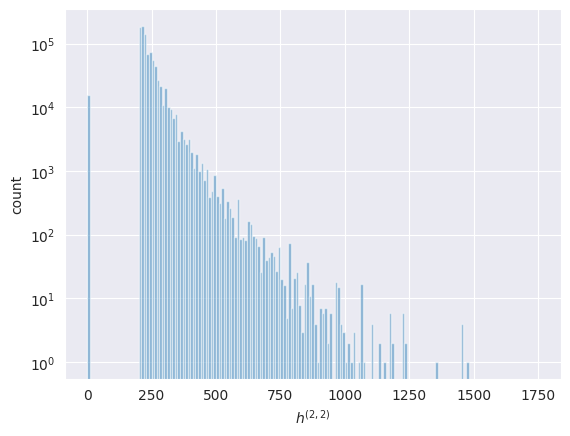

In [7]:
plt.hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
plt.xlabel('$h^{(2,2)}$')
plt.ylabel('count')
plt.yscale('log')

# Import predefined functions 

In [8]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd,  calc_accuracy

# Data preparation

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [11]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [13]:
#FIRST MODEL: SAME AS H11 PREDICTION
from CICY4_functions import ANN_cicy4_h11

# Predict h21

In [14]:
X_train, X_test, y_train, y_test = train_test(X, h21)
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

torch.Size([737197, 16, 20]) torch.Size([737197, 1]) torch.Size([184300, 16, 20]) torch.Size([184300, 1])


In [15]:
for inputs, targets in train_gen():
    print('INPUTS:' 'shape:', inputs.shape, '\n inputs:', inputs[:1])
    print('TARGETS:' 'shape:', targets.shape, '\n targets:', targets[:1])
    break

INPUTS:shape: torch.Size([128, 16, 20]) 
 inputs: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.00

In [16]:
model_h21 = ANN_cicy4_h11()
model_h21.to(device)

ANN_cicy4_h11(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_h21.parameters())

In [18]:
train_losses, test_losses=batch_gd(model_h21, criterion, optimizer, train_gen, test_gen, 100, device, 128, cnn=False)

Epoch: 1/100, train loss:  2.6840          test_loss:  2.4099, duration: 0:00:13.010837
Epoch: 2/100, train loss:  2.2063          test_loss:  2.1622, duration: 0:00:12.775106
Epoch: 3/100, train loss:  1.9413          test_loss:  1.9490, duration: 0:00:12.610042
Epoch: 4/100, train loss:  1.7330          test_loss:  1.7912, duration: 0:00:12.600516
Epoch: 5/100, train loss:  1.5600          test_loss:  1.6894, duration: 0:00:12.672296
Epoch: 6/100, train loss:  1.4259          test_loss:  1.6183, duration: 0:00:12.576893
Epoch: 7/100, train loss:  1.3035          test_loss:  1.5611, duration: 0:00:12.854775
Epoch: 8/100, train loss:  1.2055          test_loss:  1.5280, duration: 0:00:12.678349
Epoch: 9/100, train loss:  1.1176          test_loss:  1.4838, duration: 0:00:12.642902
Epoch: 10/100, train loss:  1.0353          test_loss:  1.4366, duration: 0:00:12.704824
Epoch: 11/100, train loss:  0.9668          test_loss:  1.4170, duration: 0:00:12.539637
Epoch: 12/100, train loss:  0.

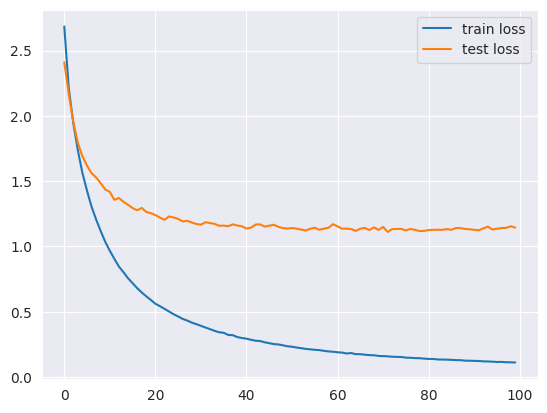

In [19]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [20]:
train_acc, test_acc = calc_accuracy(model_h21, train_gen, test_gen, device, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9001, Test acc: 0.7242


In [21]:
torch.save(model_h21, '/kaggle/working/saved_models/ANN_cicy4_h21.pt')

# Predict h31

In [22]:
X_train, X_test, y_train, y_test = train_test(X, h31)
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

torch.Size([737197, 16, 20]) torch.Size([737197, 1]) torch.Size([184300, 16, 20]) torch.Size([184300, 1])


In [23]:
model_h31 = ANN_cicy4_h11()
model_h31.to(device)

ANN_cicy4_h11(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_h31.parameters())

In [25]:
train_losses, test_losses=batch_gd(model_h31, criterion, optimizer, train_gen, test_gen,
                                   100, device, 128, cnn=False)

Epoch: 1/100, train loss:  89.6869          test_loss:  43.3245, duration: 0:00:12.482931
Epoch: 2/100, train loss:  36.2398          test_loss:  31.6267, duration: 0:00:12.438034
Epoch: 3/100, train loss:  26.4931          test_loss:  23.7602, duration: 0:00:12.421273
Epoch: 4/100, train loss:  21.5176          test_loss:  22.8057, duration: 0:00:12.636836
Epoch: 5/100, train loss:  18.6120          test_loss:  19.2147, duration: 0:00:12.450455
Epoch: 6/100, train loss:  16.5505          test_loss:  18.6686, duration: 0:00:12.540866
Epoch: 7/100, train loss:  14.8749          test_loss:  17.5144, duration: 0:00:12.501200
Epoch: 8/100, train loss:  13.5624          test_loss:  15.1309, duration: 0:00:12.442894
Epoch: 9/100, train loss:  12.4243          test_loss:  15.2069, duration: 0:00:12.466136
Epoch: 10/100, train loss:  11.4604          test_loss:  13.3933, duration: 0:00:12.528800
Epoch: 11/100, train loss:  10.7130          test_loss:  13.1179, duration: 0:00:12.472591
Epoch: 1

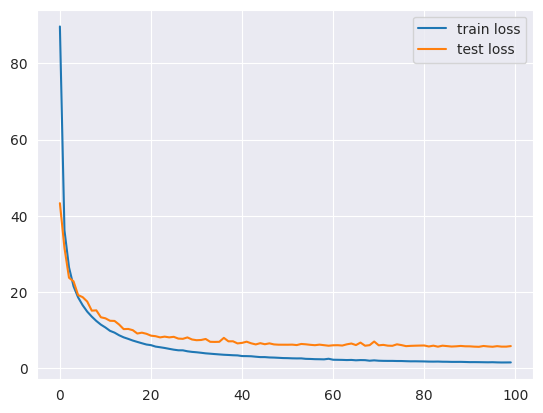

In [26]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [27]:
train_acc, test_acc = calc_accuracy(model_h31, train_gen, test_gen, device, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.4074, Test acc: 0.2764


In [28]:
torch.save(model_h31, '/kaggle/working/saved_models/ANN_cicy4_h31.pt')

# Predict h22

In [29]:
X_train, X_test, y_train, y_test = train_test(X, h22)
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

torch.Size([737197, 16, 20]) torch.Size([737197, 1]) torch.Size([184300, 16, 20]) torch.Size([184300, 1])


In [30]:
model_h22 = ANN_cicy4_h11()
model_h22.to(device)

ANN_cicy4_h11(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=1, bias=True)
)

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_h22.parameters())

In [32]:
train_losses, test_losses=batch_gd(model_h22, criterion, optimizer, train_gen, test_gen,
                                   100, device, 128, cnn=False)

Epoch: 1/100, train loss:  2451.2612          test_loss:  1447.7791, duration: 0:00:12.457804
Epoch: 2/100, train loss:  984.5009          test_loss:  774.9270, duration: 0:00:12.376694
Epoch: 3/100, train loss:  649.6268          test_loss:  678.1985, duration: 0:00:12.346726
Epoch: 4/100, train loss:  516.5688          test_loss:  505.6948, duration: 0:00:12.586016
Epoch: 5/100, train loss:  439.4387          test_loss:  432.4825, duration: 0:00:12.358436
Epoch: 6/100, train loss:  390.3996          test_loss:  396.1994, duration: 0:00:12.613141
Epoch: 7/100, train loss:  352.4010          test_loss:  369.6333, duration: 0:00:12.503485
Epoch: 8/100, train loss:  320.6329          test_loss:  355.9755, duration: 0:00:12.446915
Epoch: 9/100, train loss:  295.8180          test_loss:  345.4123, duration: 0:00:12.499718
Epoch: 10/100, train loss:  275.0794          test_loss:  309.1430, duration: 0:00:12.429248
Epoch: 11/100, train loss:  260.1981          test_loss:  306.3307, duration:

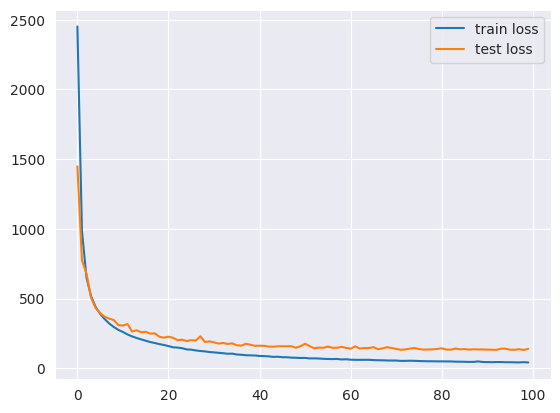

In [33]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [34]:
train_acc, test_acc = calc_accuracy(model_h22, train_gen, test_gen, device, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.0951, Test acc: 0.0761


In [35]:
torch.save(model_h22, '/kaggle/working/saved_models/ANN_cicy4_h22.pt')